# Load and test X Chromosomes

In [1]:
import allel
import h5py  # Python Package to do the HDF5.
import numpy as np
import pandas as pd
import socket
import os as os
import sys as sys
import multiprocessing as mp
import matplotlib.pyplot as plt

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

import sys
sys.path.insert(0, "./package/")  # hack to get local package first in path [FROM HARALD - DELETE!!!]

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


### Load the reference dataset

In [2]:
path_load = "./Data/1000Genomes/HDF5/1240kHDF5/all1240/chrX.hdf5"
#path_load = "./Data/SA_1240kHDF5/IPK12_downsample_ph.h5"
f = h5py.File(path_load, "r") # Load for Sanity Check. See below!
        
print("Loaded HDF5")
print("Loaded %i variants" % np.shape(f["calldata/GT"])[0])
print("Loaded %i individuals" % np.shape(f["calldata/GT"])[1])
print(list(f["calldata"].keys()))
print(list(f["variants"].keys()))

Loaded HDF5
Loaded 47898 variants
Loaded 2504 individuals
['GT']
['ALT', 'CHROM', 'FILTER_PASS', 'ID', 'MAP', 'POS', 'QUAL', 'REF']


In [4]:
f["calldata/GT"]

<HDF5 dataset "GT": shape (47900, 2504, 2), type "|i1">

### Load a target

In [6]:
path_load = "/project2/jnovembre/hringbauer/HAPSBURG/Simulated/1000G_Mosaic/TSI5/"
#path_load = "./Data/SA_1240kHDF5/IPK12_downsample_ph.h5"
ft = h5py.File(path_load, "r") # Load for Sanity Check. See below!
        
print("Loaded HDF5")
print("Loaded %i variants" % np.shape(ft["calldata/GT"])[0])
print("Loaded %i individuals" % np.shape(ft["calldata/GT"])[1])
print(list(ft["calldata"].keys()))
print(list(ft["variants"].keys()))

Loaded HDF5
Loaded 49701 variants
Loaded 1 individuals
['AD', 'GT']
['ALT', 'CH', 'MAP', 'POS', 'REF']


# Check for intersection

In [16]:
_, idx1, idx2 = np.intersect1d(f["variants/POS"], ft["variants/POS"], return_indices=True)
print(f"Intersection found: {len(idx1)} SNPs on Position")

Intersection found: 47894 SNPs on Position


In [14]:
len(idx1)

47894

In [39]:
der = ft["calldata/AD"][:, 0, 1]

In [33]:
### Calculate Mean allele frequency
p = np.mean(f["calldata/GT"][:,:,0]==1, axis=1)

In [34]:
p


array([0.44968051, 0.13857827, 0.03634185, ..., 0.49960064, 0.33426518,
       0.01317891])

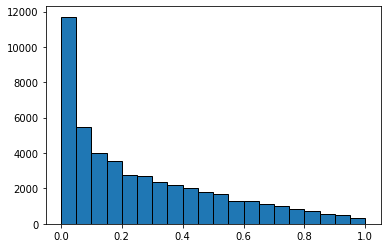

In [37]:
plt.figure()
ax=plt.gca()
ax.hist(p, ec="k", bins=20)
plt.show()

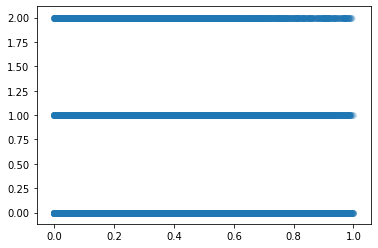

In [43]:
plt.figure()
ax=plt.gca()
ax.scatter(p[idx1], der[idx2],alpha=0.1)
plt.show()

In [44]:
np.corrcoef(p[idx1], der[idx2])

array([[ 1.        , -0.05319018],
       [-0.05319018,  1.        ]])

In [52]:
f["variants/REF"][:][idx1][:20]

array(['T', 'G', 'G', 'G', 'G', 'C', 'A', 'T', 'C', 'C', 'G', 'C', 'A',
       'C', 'A', 'G', 'G', 'T', 'A', 'T'], dtype=object)

In [53]:
f["variants/ALT"][:,0][idx1][:20]

array(['A', 'C', 'C', 'T', 'T', 'T', 'T', 'A', 'A', 'G', 'C', 'G', 'T',
       'G', 'T', 'T', 'T', 'G', 'T', 'G'], dtype=object)

In [56]:
ft["variants/REF"][:][idx2][:20]

array(['A', 'C', 'C', 'G', 'T', 'C', 'A', 'A', 'C', 'G', 'C', 'G', 'T',
       'G', 'T', 'T', 'T', 'G', 'T', 'T'], dtype=object)

In [57]:
ft["variants/ALT"][:][idx2][:20]

array(['T', 'G', 'G', 'T', 'G', 'T', 'T', 'T', 'A', 'C', 'G', 'C', 'A',
       'C', 'A', 'G', 'G', 'T', 'A', 'G'], dtype=object)

# Run hapROH on the X Chromosome

In [2]:
from hapsburg.hmm_inference import HMM_Analyze   # The HMM core object
from hapsburg.PackagesSupport.parallel_runs.helper_functions import prepare_path, multi_run, combine_individual_data

In [3]:
def hapsb_chromX(iid, save=True, save_fp=False, n_ref=2504, exclude_pops=[],
                e_model="EigenstratPacked", p_model="MosaicHDF5", readcounts=True, random_allele=True,
                post_model="Standard", path_targets = "./Data/SA_1240kHDF5/IPK12.h5",
                h5_path1000g = "./Data/1000Genomes/HDF5/1240kHDF5/all1240/chr", 
                meta_path_ref = "./Data/1000Genomes/Individuals/meta_df_all_sex.tsv",
                folder_out="./Empirical/Eigenstrat/Reichall/test/", prefix_out="",
                roh_in=1, roh_out=20, roh_jump=300, e_rate=0.01, e_rate_ref=0.0,
                max_gap=0, cutoff_post = 0.999, roh_min_l = 0.02, logfile=True):
    """Run Hapsburg analysis for one chromosome on eigenstrat data
    Wrapper for HMM Class.
    iid: IID of the Target Individual, as found in Eigenstrat [str]
    ch: Chromosome to run [float]
    path_targets: Path of the target files [str]
    h5_path1000g: Path of the reference genotypes [str]
    meta_path_ref: Path of the meta file for the references [str]
    folder_out: Path of the basis folder for output [str]
    prefix_out: Path to insert in output string, e.g. test/ [str]
    e_model: Emission model to use [str]
    p_model: Preprocessing model tu use [str]
    post_model: Model to post-process the data [str]
    processes: How many Processes to use [int]
    delete: Whether to delete raw posterior per locus [bool]
    output: Whether to print extensive output [bool]
    save: Whether to save the inferred ROH [bool]
    save_fp: Whether to save the full posterior matrix [bool]
    n_ref: Number of (diploid) reference Individuals to use [int]
    exclude_pops: Which populations to exclude from reference [list of str]
    readcounts: Whether to load readcount data [bool]
    random_allele: Whether to pick a random of the two target alleles per locus [bool]
    roh_in: Parater to jump into ROH state (per Morgan) [float]
    roh_out: Parameter to jump out of ROH state (per Morgan) [float]
    roh_jump: Parameter to jump (per Morgan) [float]
    e_rate: Error rate target [float]
    e_rate_ref: Error rate refernce [float]
    cutoff_post: Posterior cutoff [float]
    max_gap: Maximum gap to merge (Morgan) [float]
    roh_min_l: Minimum length ROH (Morgan) [float]
    logfile: Whether to use logfile [bool]
    combine: Wether to combine output of all chromosomes [bool]
    file_result: Appendix to individual results [string]"""
    
    hmm = HMM_Analyze(cython=2, p_model=p_model, e_model=e_model,
                      manual_load=True, save=save, save_fp=save_fp)

    ### Load and prepare the pre-processing Model
    hmm.load_preprocessing_model()              # Load the preprocessing Model
    hmm.p_obj.set_params(readcounts = readcounts, random_allele=random_allele,
                         folder_out=folder_out, prefix_out_data=prefix_out, 
                         excluded=exclude_pops, 
                         diploid_ref=False, samples_field= "inds/samples")
    
    ### Set the paths to ref & target
    hmm.p_obj.set_params(h5_path1000g = h5_path1000g, path_targets = path_targets, 
                         meta_path_ref = meta_path_ref, n_ref=n_ref)
    hmm.load_data(iid=iid, ch="X")  # Load the actual Data
    hmm.load_secondary_objects()

    ### Set the Parameters
    hmm.e_obj.set_params(e_rate = e_rate, e_rate_ref = e_rate_ref)
    hmm.t_obj.set_params(roh_in=roh_in, roh_out=roh_out, roh_jump=roh_jump)
    hmm.post_obj.set_params(max_gap=max_gap, cutoff_post=cutoff_post, roh_min_l = roh_min_l)
    
    ### hmm.calc_viterbi_path(save=save)           # Calculate the Viterbi Path.
    hmm.calc_posterior(save=save)              # Calculate the Posterior.
    hmm.post_processing(save=save)             # Do the Post-Processing.

In [5]:
hapsb_chromX(iid="I15590_I15963", save=True, save_fp=False, n_ref=2504, exclude_pops=[],
                e_model='readcount', p_model='MosaicHDF5', readcounts=True, random_allele=False,
                post_model="Standard", logfile=False, 
                path_targets = "/project2/jnovembre/hringbauer/caribbean_roh/data/hdf5/ibdx/test.h5",
                h5_path1000g = "./Data/1000Genomes/HDF5/1240kHDF5/all1240/chr", 
                meta_path_ref = "./Data/1000Genomes/Individuals/meta_df_all_sex.tsv",
                folder_out="./Empirical/dumpster/testx/")

Using Low-Mem Cython Linear Speed Up.
Loaded Pre Processing Model: MosaicHDF5
Loading Individual: I15590_I15963

Loaded 49701 variants
Loaded 1 individuals
HDF5 loaded from /project2/jnovembre/hringbauer/caribbean_roh/data/hdf5/ibdx/test.h5

Loaded 47898 variants
Loaded 2504 individuals
HDF5 loaded from ./Data/1000Genomes/HDF5/1240kHDF5/all1240/chrX.hdf5

Intersection on Positions: 47894
Nr of Matching Refs: 9790 / 47894
Ref/Alt Matching: 9772 / 47894
Flipped Ref/Alt Matching: 37993
Together: 47765 / 47894
2504 / 2504 Individuals included in Reference
Extracting up to 2504 Individuals
Extraction of 2 Haplotypes complete
Flipping Ref/Alt in target for 37993 SNPs...
Extraction of 2504 Haplotypes complete
Reduced to markers called 21271 / 47765
Fraction SNPs covered: 0.4453
Successfully saved to: ./Empirical/dumpster/testx/I15590_I15963/chrX/
Loading Readcounts...
Mean Readcount markers loaded: 1.32791
Successfully loaded Data from: ./Empirical/dumpster/testx/I15590_I15963/chrX/
Loaded Em

### Test 2nd pair with long ROH

In [9]:
%%time
hapsb_chromX(iid="I15965_I16171", save=True, save_fp=False, n_ref=2504, exclude_pops=[],
                e_model='readcount', p_model='MosaicHDF5', readcounts=True, random_allele=False,
                post_model="Standard", logfile=False, 
                path_targets = "/project2/jnovembre/hringbauer/caribbean_roh/data/hdf5/ibdx/test2.h5",
                h5_path1000g = "./Data/1000Genomes/HDF5/1240kHDF5/all1240/chr", 
                meta_path_ref = "./Data/1000Genomes/Individuals/meta_df_all_sex.tsv",
                folder_out="./Empirical/dumpster/testx/")

Using Low-Mem Cython Linear Speed Up.
Loaded Pre Processing Model: MosaicHDF5
Loading Individual: I15965_I16171

Loaded 49701 variants
Loaded 1 individuals
HDF5 loaded from /project2/jnovembre/hringbauer/caribbean_roh/data/hdf5/ibdx/test2.h5

Loaded 47898 variants
Loaded 2504 individuals
HDF5 loaded from ./Data/1000Genomes/HDF5/1240kHDF5/all1240/chrX.hdf5

Intersection on Positions: 47894
Nr of Matching Refs: 9790 / 47894
Ref/Alt Matching: 9772 / 47894
Flipped Ref/Alt Matching: 37993
Together: 47765 / 47894
2504 / 2504 Individuals included in Reference
Extracting up to 2504 Individuals
Extraction of 2 Haplotypes complete
Flipping Ref/Alt in target for 37993 SNPs...
Extraction of 2504 Haplotypes complete
Reduced to markers called 21263 / 47765
Fraction SNPs covered: 0.4452
Successfully saved to: ./Empirical/dumpster/testx/I15965_I16171/chrX/
Loading Readcounts...
Mean Readcount markers loaded: 1.42017
Successfully loaded Data from: ./Empirical/dumpster/testx/I15965_I16171/chrX/
Loaded E

### On haploid genotypes

In [8]:
%%time
hapsb_chromX(iid="I15965_I16171", save=True, save_fp=False, n_ref=2504, exclude_pops=[],
                e_model='haploid', p_model='MosaicHDF5', readcounts=False, random_allele=False,
                post_model="Standard", logfile=False, 
                path_targets = "/project2/jnovembre/hringbauer/caribbean_roh/data/hdf5/ibdx/test2.h5",
                h5_path1000g = "./Data/1000Genomes/HDF5/1240kHDF5/all1240/chr", 
                meta_path_ref = "./Data/1000Genomes/Individuals/meta_df_all_sex.tsv",
                folder_out="./Empirical/dumpster/testx/")

Using Low-Mem Cython Linear Speed Up.
Loaded Pre Processing Model: MosaicHDF5
Loading Individual: I15965_I16171

Loaded 49701 variants
Loaded 1 individuals
HDF5 loaded from /project2/jnovembre/hringbauer/caribbean_roh/data/hdf5/ibdx/test2.h5

Loaded 47898 variants
Loaded 2504 individuals
HDF5 loaded from ./Data/1000Genomes/HDF5/1240kHDF5/all1240/chrX.hdf5

Intersection on Positions: 47894
Nr of Matching Refs: 9790 / 47894
Ref/Alt Matching: 9772 / 47894
Flipped Ref/Alt Matching: 37993
Together: 47765 / 47894
2504 / 2504 Individuals included in Reference
Extracting up to 2504 Individuals
Extraction of 2 Haplotypes complete
Flipping Ref/Alt in target for 37993 SNPs...
Extraction of 2504 Haplotypes complete
Reduced to markers called 16885 / 47765
Fraction SNPs covered: 0.3535
Successfully saved to: ./Empirical/dumpster/testx/I15965_I16171/chrX/
Successfully loaded Data from: ./Empirical/dumpster/testx/I15965_I16171/chrX/
Loaded Emission Model: haploid
Loaded Transition Model: model
Loaded 